In [1]:
%matplotlib inline

In [3]:
from itertools import product

import numpy as np
import matplotlib.pyplot as plt

from mne import (
    read_epochs,
    concatenate_epochs,
    EpochsArray,
    create_info,
    combine_evoked,
)
from mne.decoding import CSP
from mne.viz import plot_compare_evokeds, plot_evoked_topo, plot_sensors
from mne.time_frequency import psd_multitaper, tfr_array_morlet, tfr_morlet
from mne import set_log_level, concatenate_epochs
from mne.stats import permutation_cluster_test

from mne_bids import get_entities_from_fname

# custom imports
from config import EPOCHS_DIR


set_log_level(verbose="ERROR")

n_channels = 204
n_times = 1001

LOW_CONF_EPOCH = 24
HIGH_CONF_EPOCH = 44

In [3]:
good_subjs = [
    "sub-01",
#     "sub-03",
    "sub-04",
    "sub-05",
    "sub-08",
    "sub-09",
    "sub-12",
    "sub-13",
    "sub-14",
    "sub-16",
]
def read_data():
    """Read in epochs"""
    fif_files = EPOCHS_DIR.rglob("*-epo.fif")
    epochs = {}
    for fif_file in fif_files:
        if fif_file.name[:6] not in good_subjs:
            continue
        bids_base = BidsFname(fif_file.name[: -len("-epo.fif")])
        subj = bids_base.to_string("sub")
        ep = read_epochs(fif_file).interpolate_bads().pick_types(meg="grad")["answer"]
        
        # required to merge epochs from differen subjects together
        ep.info["dev_head_t"] = None
        
        epochs[subj] = ep
    return epochs


def assemble_data(epochs):
    """Prepare data for scikit-learn style functions"""
    X = np.empty((0, n_channels, n_times))
    y = np.empty(0)
    for subj in epochs:
        if subj in ("sub-02"):  # skip sub-02
            continue
        if subj not in good_subjs:
            continue
        print(subj.upper())
        ep = epochs[subj]
        X_low = ep["low"].get_data()
        y_low = ep["low"].events[:, 2]
        X_high = ep["high"].get_data()
        y_high = ep["high"].events[:, 2]
        X = np.r_[X, X_low, X_high]
        y = np.r_[y, y_low, y_high]
        print(f"# epochs low: {len(y_low)}, # epochs high: {len(y_high)}")
    return X, y


# Data preparation

For the analysis we took 2-second preprocessed epochs with times from -1
to 1 second with zero being an answers onset and -1 being a fixation
cross onset.

Preprocessing steps for the epochs were as follows:

    1. Maxwell filtering with SSS.
    2. frequency filtering in 1-100 Hz band.
    3. downsampling from 1000 Hz to 500 Hz.
    4. ECG, EOG, muscle and acquisition artefacts removal with ICA.
    5. manual removal of bad epochs.

For this analysis only the gradiometers were taken.

The idea for this analysis was to compare low confidence epochs with the high confidence ones.
In order to do that we decided to look into differences in `ERFs` (evoked activity) and also in powers (induced activity) with the stress on the latter since it's not clear weither there should be any strong phase locking relative to the stimuli onset.

## Addressing low number of epochs

Since there aren't so many epochs for each subject and very few subjects recorded so far, we
can't really do the averaging within each subject and then compare the averages between subjects
as we would normally do.
Therefore we merged all the epochs together as though they were all coming from one subject.

We had to exclude sub-02 (Gavrilchuk Stanislav) since he had only 2 answers within the high confidence reference values and 0 answers within the low confidence. This isn't due to the bad epochs being dropped during the manual inspection step. Rather it's
because of the way the subject marked his level of confidence: most of his answers fall into the lowest, the highest and the middle-confidence bin.

In [4]:
# load the data
epochs = read_data()  # dict with subj -> epochs mapping
info = epochs["sub-01"].info
X, y = assemble_data(epochs)
print(f"Data shape is [{X.shape[0]} epochs, {X.shape[1]} sensors, {X.shape[2]} samples]")

SUB-04
# epochs low: 23, # epochs high: 39
SUB-13
# epochs low: 30, # epochs high: 33
SUB-01
# epochs low: 50, # epochs high: 17
SUB-09
# epochs low: 32, # epochs high: 18
SUB-08
# epochs low: 30, # epochs high: 31
SUB-05
# epochs low: 12, # epochs high: 35
SUB-12
# epochs low: 17, # epochs high: 40
SUB-14
# epochs low: 32, # epochs high: 29
SUB-16
# epochs low: 32, # epochs high: 37
Data shape is [537 epochs, 204 sensors, 1001 samples]


# Event related field analysis
The objective here is to see if there's any activiy that is phase locked to the stimuli onset and
if there's any difference in this activity between the low- and high-confidence epochs.

To study the phase-locked activity we split the epochs into low and high confidence groups and average within each group.
We also compute the difference between these averages.

In case of EEG averaged phase-locked activation is called Event Related Potential or `ERP`. In case of MEG Event Related Field or `ERF`
abbreviation is more common for the same type of plot.

In [5]:
erf_low = EpochsArray(X[y == LOW_CONF_EPOCH, ...], info, tmin=-1).average()
erf_high = EpochsArray(X[y == HIGH_CONF_EPOCH, ...], info, tmin=-1).average()
erf_diff = combine_evoked([erf_low, -erf_high], weights="equal")

## ERF plots
To visualize the evoked activity we plot the `ERF` responses for low and high confidence conditions
and manually marked the peaks to visualize their topographies. We also plot the difference between `ERFs` in these two conditions.

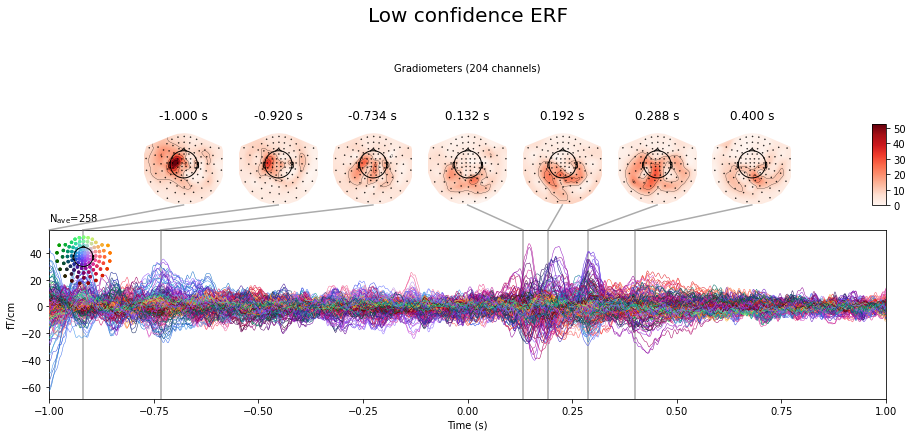

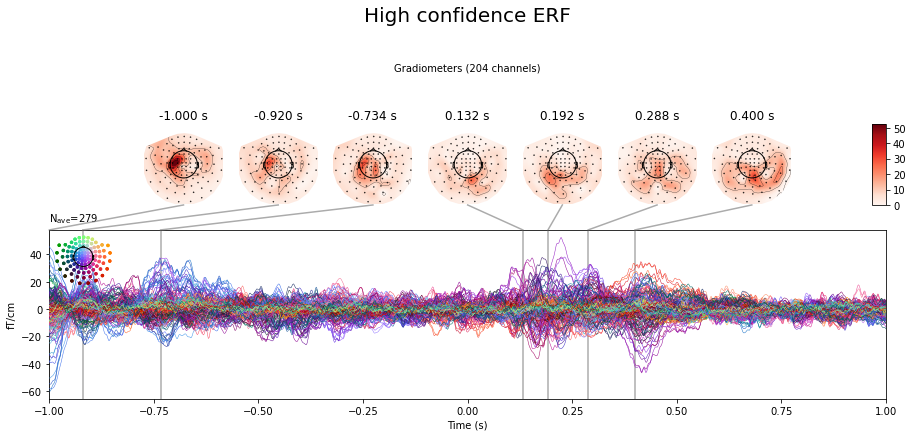

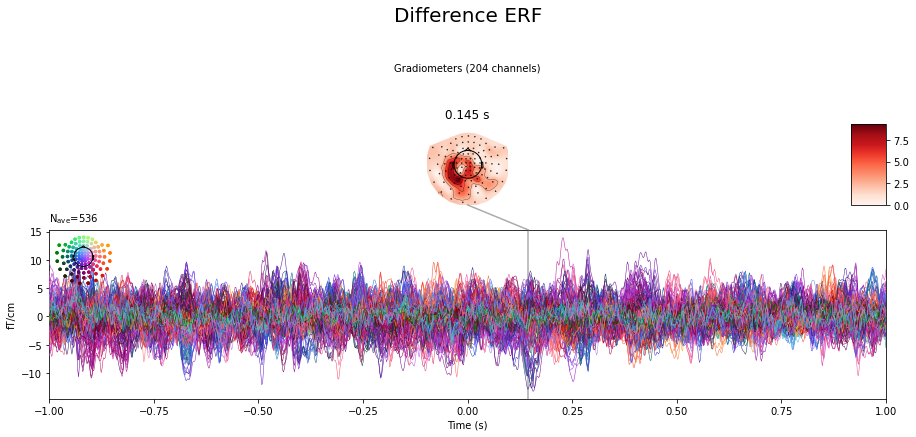

In [6]:
f1 = erf_low.plot_joint(times=[-1, -0.92, -0.734, 0.132, 0.192, 0.288, 0.4], show=False)
f1.set_size_inches(14, 6)
plt.title("Low confidence ERF",fontsize=20)

f2 = erf_high.plot_joint(times=[-1, -0.92, -0.734, 0.132, 0.192, 0.288, 0.4], show=False)
f2.set_size_inches(14, 6)
plt.title("High confidence ERF",fontsize=20)

f3 = erf_diff.plot_joint(times=[0.145], show=False);
f3.set_size_inches(14, 6)
plt.title("Difference ERF",fontsize=20);

Two leftmost topographies for both low and high confidence conditions clearly show response in the left motor area.
It aligns well with the fact that the subjects were pressing button just before the fixation cross onset.

Altogether there are some distinct `ERF` peaks for low and high conditions that might be of interest but require
accurate interpretation.

The difference `ERF` doesn't show that much of a difference which confirms the initial guess that there shouldn't
be much task related phase-locked activiy.

In order to get more sense of what's going on with the difference we plotted  `ERFs` for low and high conditions alonside for a selected number of sensors (see the figures below).

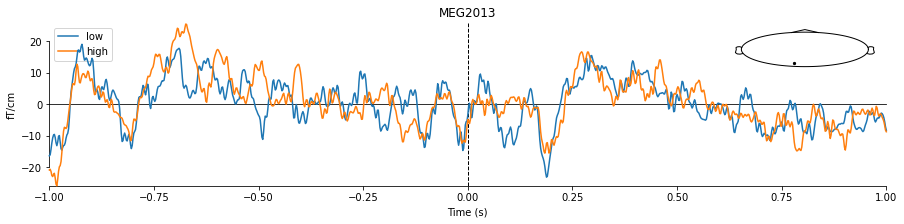

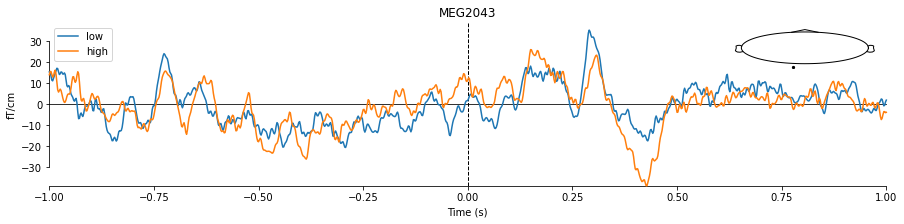

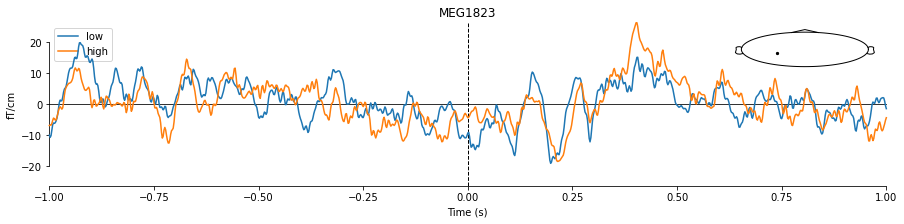

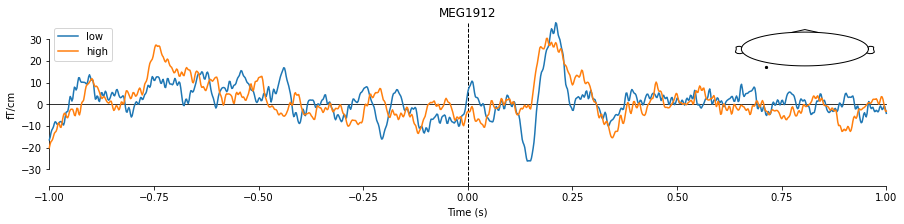

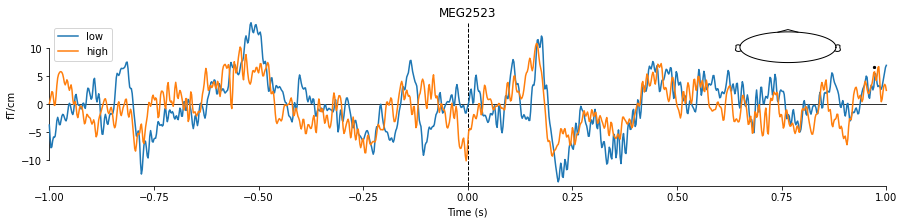

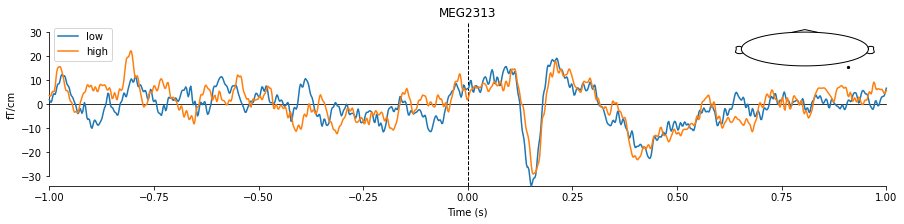

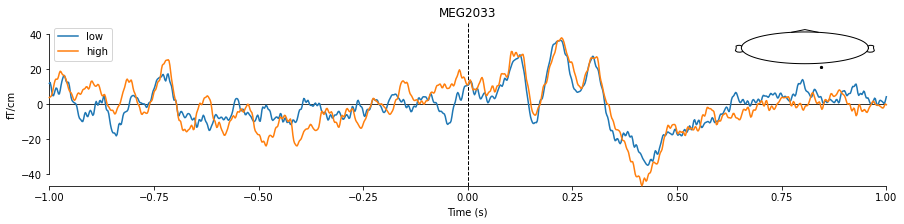

In [7]:
for ch in [
    "MEG2013", "MEG2043", "MEG1823", "MEG1912", "MEG2523", "MEG2313", "MEG2033"
]:
    pick = erf_low.ch_names.index(ch)
    figs = plot_compare_evokeds(
        {"low": erf_low, "high": erf_high}, picks=pick, show=False
    )
    figs[0].set_size_inches(15,3)


# Power analysis

In order to study activity that is not necesserily phase-locked to the stimuli but manifesting itself
in the form of increasing amplitude of oscillations on certain frequencies we compare the power of oscillations
between the conditions.

In [8]:
ep = {}
ep['high'] = concatenate_epochs([epochs[k]['high'] for k in epochs])
ep['low'] = concatenate_epochs([epochs[k]['low'] for k in epochs if "answer/low" in epochs[k].event_id])
ep_all = concatenate_epochs([ep['low'], ep['high']])

## PSD topomaps in standard frequency bands
In this section we compute PSD for each sensor and plot power distribution
across sensors in standard frequency bins.

We compute PSD for two time intervals: fixation cross and answers.

In [15]:
t = ep["high"]

In [50]:
t.plot_psd_topomap??

In [79]:
np.where(psds_merge < 0)

(array([], dtype=int64), array([], dtype=int64))

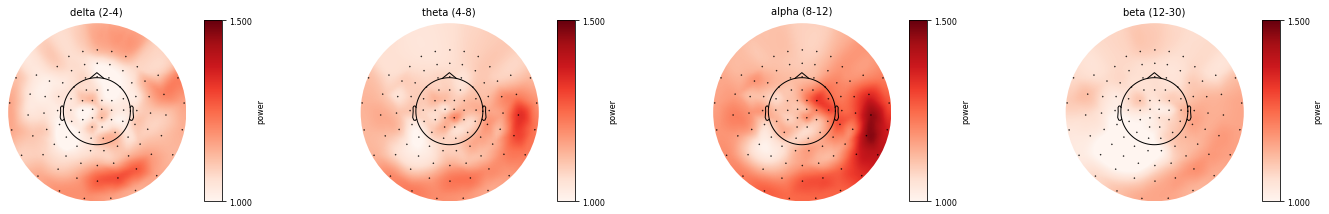

In [155]:
# Power difference distribution
from mne.viz.topomap import plot_psds_topomap, _prepare_topomap_plot, _make_head_outlines
from mne.channels.channels import _get_ch_type
from mne.defaults import _handle_default
from mne.channels.layout import _merge_ch_data

from mne.time_frequency import psd_multitaper

# Answer condition
psds_high, freqs = psd_multitaper(ep["high"], tmin=0, tmax=1)
psds_low, freqs = psd_multitaper(ep["low"], tmin=0, tmax=1)

# Question condition
# psds_high, freqs = psd_multitaper(ep["high"], tmin=-1, tmax=0)
# psds_low, freqs = psd_multitaper(ep["low"], tmin=-1, tmax=0)

psds = psds_high.mean(axis=0) / psds_low.mean(axis=0)
ch_type = _get_ch_type(ep["high"], None)
units = _handle_default('units', None)
unit = units[ch_type]

picks, pos, merge_channels, names, ch_type, sphere, clip_origin = \
    _prepare_topomap_plot(ep["low"], ch_type, sphere=None)
outlines = _make_head_outlines(sphere, pos, "head", clip_origin)

if merge_channels:
    psds_merge, names = _merge_ch_data(psds, ch_type, names, method='mean')

fig = plot_psds_topomap(
    psds_merge,
    freqs,
    dB=False,
    vlim=(1,1.5),
    bands=[
        (2, 4, 'delta (2-4)'),
        (4, 8, 'theta (4-8)'),
        (8, 12, 'alpha (8-12)'),
        (12, 30, 'beta (12-30)')
    ],
    pos=pos,
    outlines=outlines,
    sphere=sphere,
    show=False
)
fig.set_size_inches((20,10))

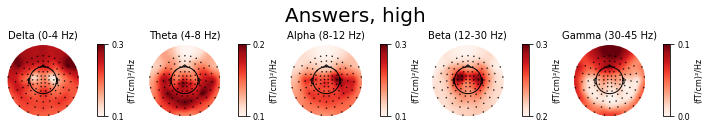

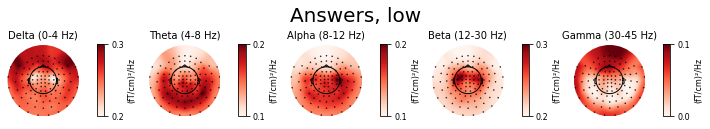

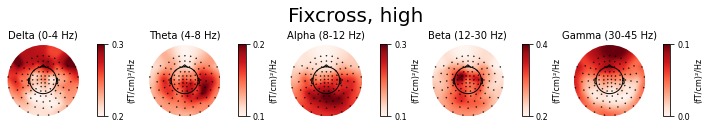

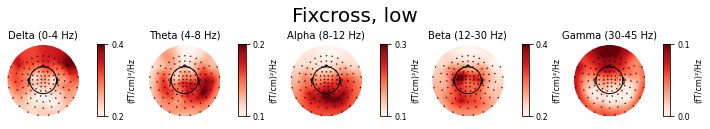

In [9]:
suptitle_kwargs = dict(fontsize=20, verticalalignment="bottom")
topomap_kwargs = dict(normalize=True, show=False)
intervals = {"Answers": (0, 1), "Fixcross": (-1, 0)}

for i, cond in product(intervals, ep):
    fig = ep[cond].plot_psd_topomap(tmin=intervals[i][0], tmax=intervals[i][1], **topomap_kwargs);
    fig.suptitle(t=f"{i}, {cond}" , **suptitle_kwargs)

Distributions for fixcross and answers intervals look pretty much the same except for big changes in alpha
distribution and not so big changes in beta (notice peak in left occipital region for beta in fixcross condition)

## Time-frequency topomap
Let's see, how power in the two conditions unravels in time.
For that we compute time-frequency map for each sensor and plot them together on one topomap
for each condition.

In [174]:
freqs = np.arange(1.0, 30.0, 1.0)
n_cycles = freqs / 2.0

tfr = {}
for c in ep:
    tfr[c] = tfr_morlet(
        ep[c], freqs=freqs, n_cycles=n_cycles, decim=4, use_fft=True, average=False, return_itc=False
    )

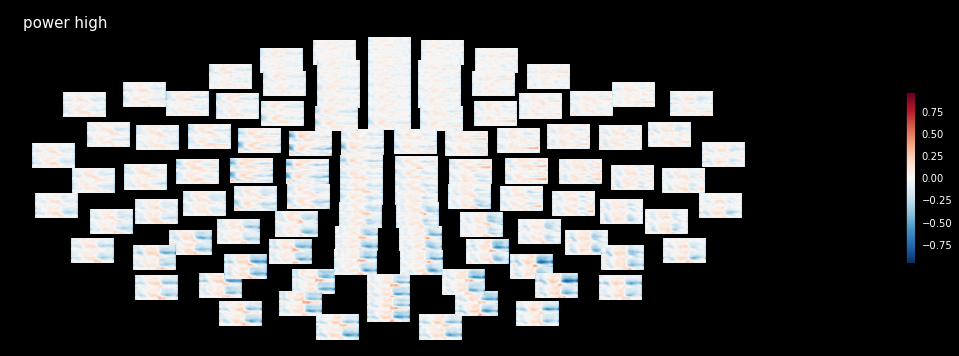

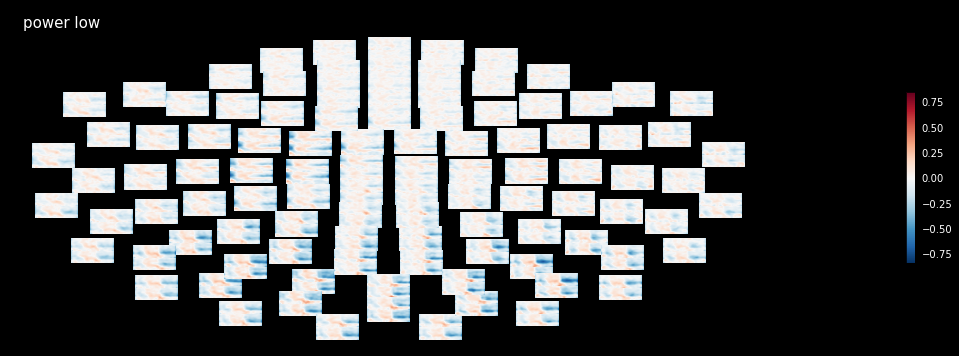

In [175]:
for c in ep:
    fig = tfr[c].average().plot_topo(show=False, title=f"power {c}", baseline=(-1,0), mode='logratio')
    fig.set_size_inches((15,5))

In [188]:
diff_tfr.data.min()

-1.0741995613158837e-21

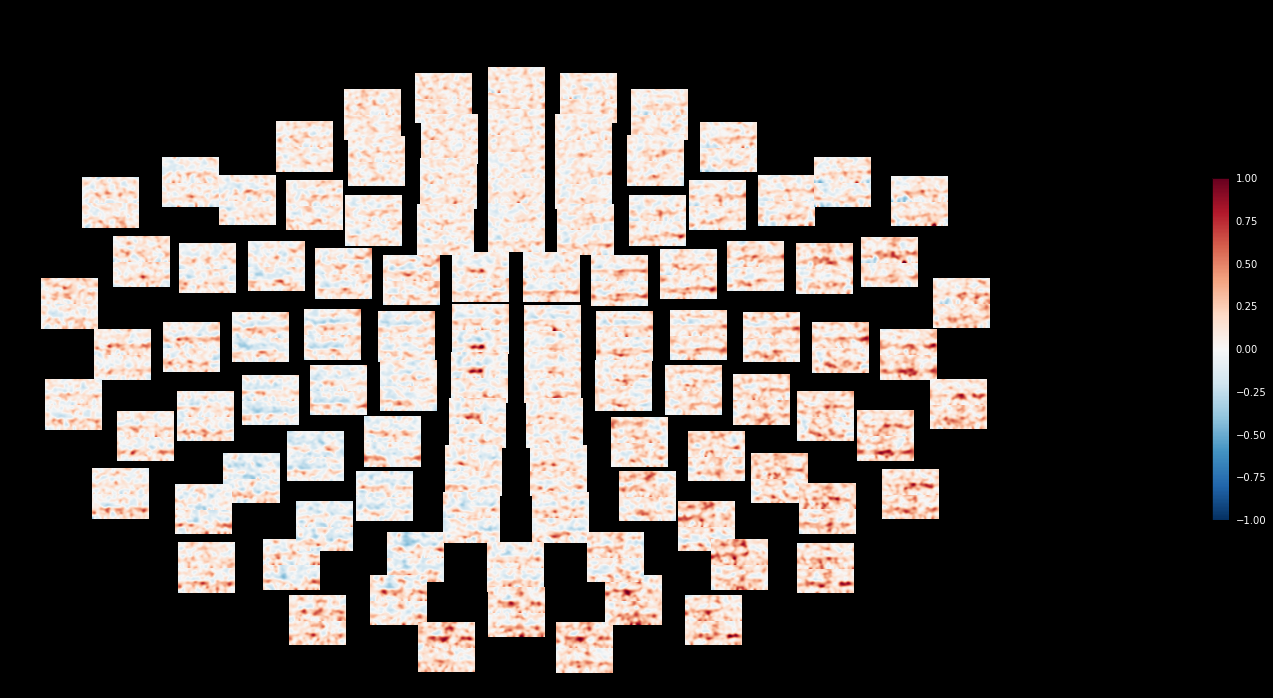

In [208]:
avg_high = tfr["high"].average()
avg_low = tfr["low"].average()
diff_tfr = avg_low.copy()
diff_tfr.data = (avg_high.data - avg_low.data) / avg_low.data
fig = diff_tfr.plot_topo(show=False, vmin=-1, vmax=1)
fig.set_size_inches((20,10))

There's slight discrepancy between low and high confidence conditions in the right motor area.
Let's plot sensors to find the channel which shows the most prominent difference.

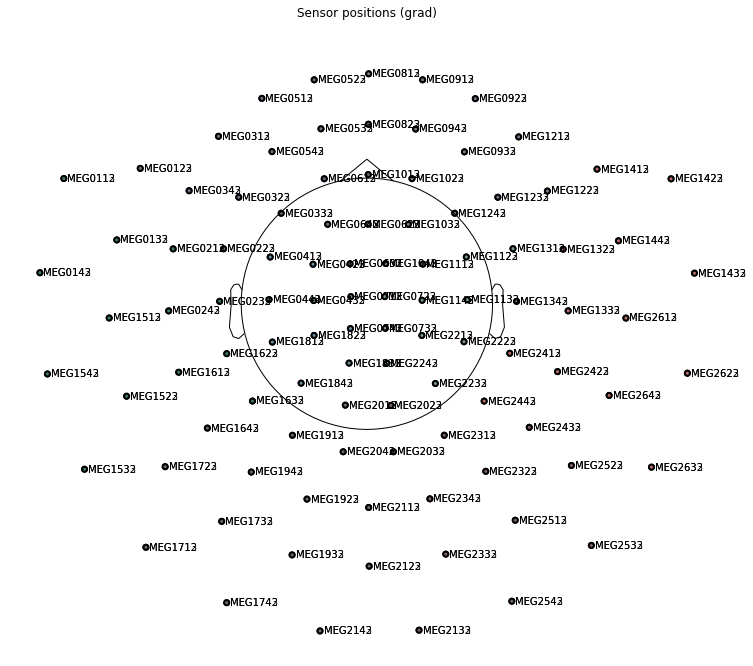

In [34]:
f = plot_sensors(ep_all.info, show_names=True, show=False, ch_groups='position')
f.set_size_inches((10, 10))

From the sensors plot we get the channel name MEG1113 as the channel for which time-frequency maps seem to differ on the previous figure. Let's plot TFR map for this channel separately to
see more details:

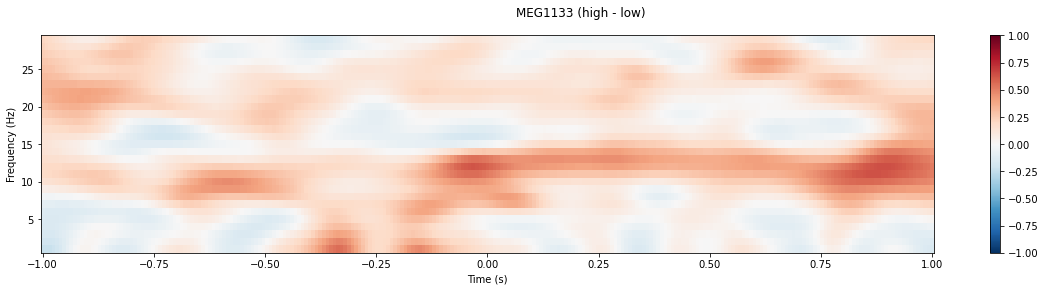

In [211]:
sen = tfr['low'].ch_names.index('MEG1133')

fig = diff_tfr.plot(
    [sen],
    title=tfr['low'].ch_names[sen] +  f" (high - low)",
    show=False,
    vmin=-1,
    vmax=1,
)
fig.set_size_inches(20, 4)

In [146]:
tfr_diff = tfr["high"].average() - tfr["low"].average()

In [101]:
tfr_diff.data = tfr["high"].average().data / tfr["low"].average().data

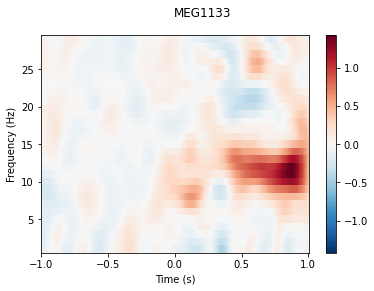

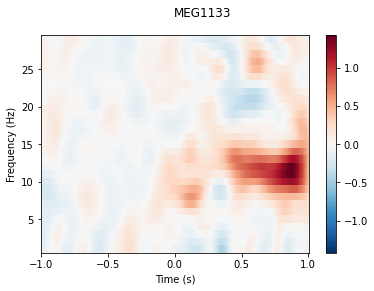

In [149]:
tfr_diff.plot(["MEG1133"])

Here the difference between low and high is more obvious. Frequency range is from 9 to 14 Hz. Let's see if this
difference is significant. First we extract data for this sensor and apply baseline correction. For the baseline
we take the fixation cross interval because we don't have any better option.

In [143]:
tfr_1113 = {}
freqs = np.arange(1.0, 30.0, 1.0)
for c in ep:
    tfr_1113[c] = tfr[c].pick_channels(ch_names=["MEG1133"])
#     tfr_1113[c] = tfr[c].pick_channels(ch_names=["MEG1732"])
    tfr_1113[c].apply_baseline(mode='ratio', baseline=(-1, 0))
#     tfr_1113[c].average().plot(vmin=0, vmax=3, cmap="Reds", title=f"{c}");

In [135]:
tfr_1113["high"].info

<Info | 22 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 bads: []
 ch_names: MEG1133
 chs: 1 GRAD
 custom_ref_applied: False
 description: Vectorview system
 dig: 208 items (3 Cardinal, 4 HPI, 201 Extra)
 events: 1 item (list)
 experimenter: meg
 file_id: 4 items (dict)
 highpass: 1.0 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 hpi_subsystem: 3 items (dict)
 line_freq: 50.0
 lowpass: 100.0 Hz
 meas_date: 2020-02-29 14:41:03 UTC
 meas_id: 4 items (dict)
 nchan: 1
 proc_history: 1 item (list)
 proj_id: 1 item (ndarray)
 proj_name: metacognition
 projs: []
 sfreq: 125.0 Hz
 subject_info: 6 items (dict)
>

In [133]:
cluster_pv < 0.05

array([False, False, False, False, False,  True, False, False, False,
       False, False, False])

In [130]:
thresh_pv = 0.05
F_obs, clusters, cluster_pv, H0 = \
    permutation_cluster_test(
    [tfr_1113["high"].data[:,0,...], tfr_1113["low"].data[:,0,...]],
    n_permutations=100,
    tail=0
)
good_clusters = (np.where(cluster_pv < thresh_pv)[0])
if good_clusters.size:
    mask = np.logical_or.reduce(np.array(clusters)[good_clusters], axis=0)
else:
    mask = np.zeros_like(F_obs, dtype=bool)
F_obs_plot = np.ma.masked_array(F_obs, np.invert(mask))

For statistics we do one-way ANOVA for each time-frequency point and do cluster-level permutation-based statistics to correct for multiple comparisons.

<ipython-input-212-2a6af11f1a8f>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(
<ipython-input-212-2a6af11f1a8f>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = ax.pcolormesh(tfr_1113['high'].times * 1000, freqs, F_obs_plot, cmap=plt.cm.viridis)


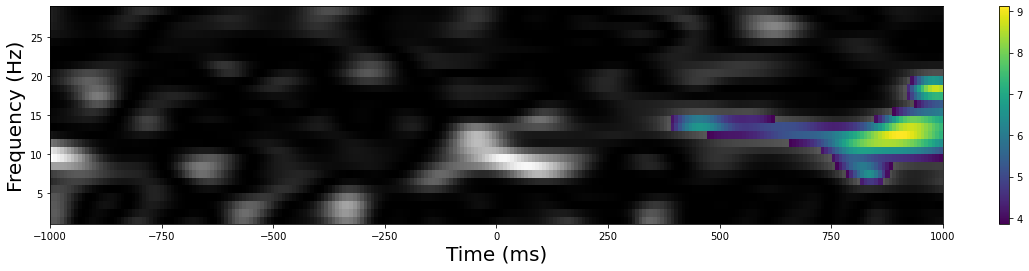

In [212]:
fig, ax = plt.subplots()
freqs = np.arange(1.0, 30.0, 1.0)
ax.pcolormesh(
    tfr_1113['high'].times * 1000,
    freqs,
    F_obs,
    cmap=plt.cm.gray,
)
mesh = ax.pcolormesh(tfr_1113['high'].times * 1000, freqs, F_obs_plot, cmap=plt.cm.viridis)
ax.set(ylim=freqs[[0, -1]], xlabel="Time (ms)", ylabel="Frequency (Hz)")
ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
fig.colorbar(mesh, ax=ax)
fig.set_size_inches(20, 4)
plt.show()

On the picture above we show our F-statistic with the siginficant part of the plot in color.
The plot shows that our effect in alpha -- low beta range with latency from 300 to 1000 ms is significant (p < 0.05)

## CSP components.

### Motivation
Some dimensionality reduction would be useful. We have a total of 204 sensors in our analysis which is too big of a number to compare the data conveniently.

On the other hand we would like to use the spatial information to highlight the difference between two conditions,
ideally in some optimal way. 

In order to achieve both we use here a technique that is called [Common Spatial Pattern](https://en.wikipedia.org/wiki/Common_spatial_pattern) or `CSP`.

### CSP intuition.
In brief, `CSP` aims at combining signals from different sensors in such a way that the resulting signal
maximizes signal power for one condition while minimizing it for another.

`CSP` achieves this by computing two covariance matrices, one for each condition, and looking for filters that
give maximum power when applied to the first covariance while giving minimum power when applied to the second.

*N.B.:* there can be more such filters than one. The number of filters is set by the user.

When we apply these filters to data the resuling time series are called `CSP components`.

The most common application of `CSP` techinique is in motor imagery brain-computer interfaces (BCI).
[Here](https://mne.tools/dev/auto_examples/decoding/plot_decoding_csp_eeg.html) you can find an example from the MNE-python tutorials webpage on the application of CSP to BCI with paper references.

### CSP application details concerning our data
In our case we feed into the `CSP` algorithm two types of epochs: low and high confidence.
**We fit the algorithm on the \[0, 1\] time interval** to focus on the activity occuring after the answers onset.
We don't use the fixcross interval so the mu-rhythm related to the button press doesn't affect the filters.

We set the number of `CSP` filters to 2 because only the first 2 components show distinct spatial structure (see the *CSP components plot*). Setting the number of components to higher values doesn't give components with such pronounced topographies.

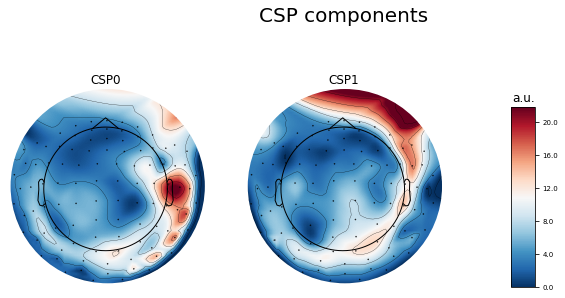

In [59]:
n_comp = 2
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

csp = CSP(n_components=n_comp, transform_into="csp_space", reg=0.8)
# X = np.random.rand(*X.shape)
csp.fit(X_train[:, :, 500:], y_train)  # 500-th sample corresponds to answers onset
times = epochs["sub-01"].times
fig = csp.plot_patterns(info, show=False)
fig.set_size_inches(10, 5)
fig.suptitle("CSP components", fontsize=20);

On the topographies above we show the spatial distribution for the two CSP components we've computed. These topographies show spatial patterns
of activations where the power for high confidence condition was the highest compared to the power of the low confidence condition. 

Note that `component 0` shows activation in the right motor area. Arguably this might be related to the subjects getting ready to answer the question with a button press when they feel more confident with the answer.
Although it's not clear why this should happen in the right hemisphere. It might as well be related to metamemory.

## ERP for CSP components

Below we plot evoked responses for the `CSP` components we've computed.

Note that activation for these components isn't supposed to show maximum difference for the `ERFs` since `CSP` is tuned
to segregate signals by average power, not by the amplitude of the phase-locked response.

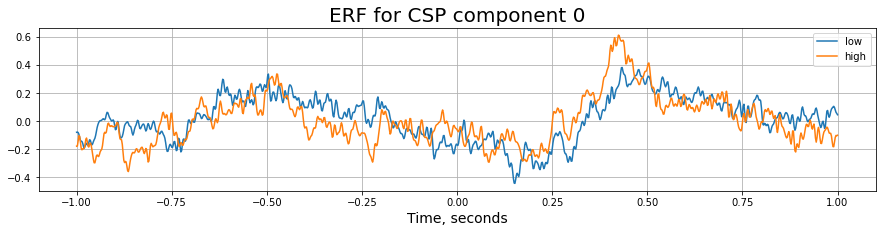

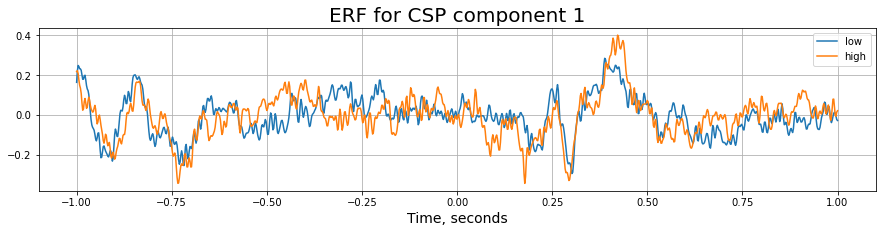

In [60]:
for i_comp in range(n_comp):
    X_csp = csp.transform(X_test)
    X_av_low = X_csp[y_test == LOW_CONF_EPOCH, :, :].mean(axis=0)
    X_av_high = X_csp[y_test == HIGH_CONF_EPOCH, :, :].mean(axis=0)
    plt.plot(times, X_av_low[i_comp, :])
    plt.plot(times, X_av_high[i_comp, :])
    plt.grid()
    plt.legend(["low", "high"])
    plt.title(f"ERF for CSP component {i_comp}", fontsize=20)
    plt.xlabel("Time, seconds", fontsize=14)
    plt.gcf().set_size_inches(15, 3)
    plt.show()

ERF for CSP components shows some difference for the 0-th component which had power bump in the occipital area (see the *CSP components* plot)

## Power spectral density difference for CSP components.
The `CSP` components provide us filters that show maximum difference in power between two conditions. But they
don't tell us which frequencies contribute most to the difference in power we observe. To get an idea on what
frequencies increase their power in the high confidence epochs compared to low we compute the [power spectral density](https://en.wikipedia.org/wiki/Spectral_density) (`PSD`) for each condition. 

### PSD computation details.
We compute power spectral density only for the time interval **after the answers onset** (\[0, 1\] seconds interval) since we've fit `CSP` on this interval.

For the computation we use the `multitaper` method. A good tutorial comparing different methods for
`PSD` estimation can be found [here](https://raphaelvallat.com/bandpower.html).

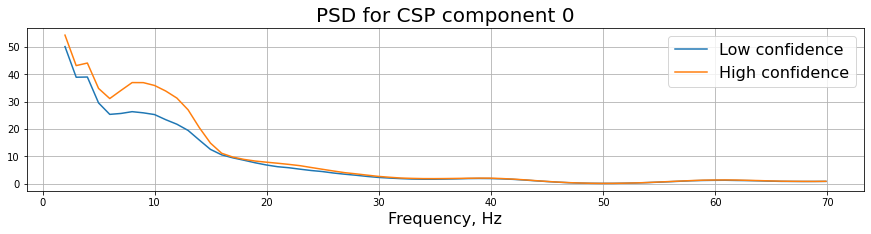

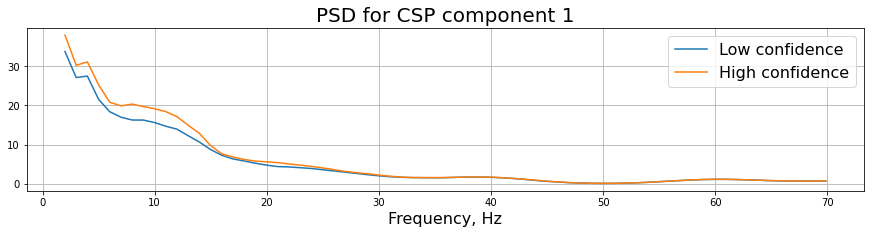

In [61]:
X_csp_low = X_csp[y_test == LOW_CONF_EPOCH, :, :]
X_csp_high = X_csp[y_test == HIGH_CONF_EPOCH, :, :]
info_psd = create_info(n_comp, info["sfreq"], ch_types=["grad"] * n_comp)

for i_comp in range(n_comp):
    ep_psd_low = EpochsArray(X_csp_low[:, :, 500:], info_psd)
    ep_psd_high = EpochsArray(X_csp_high[:, :, 500:], info_psd)
    psd_low, freqs_psd = psd_multitaper(ep_psd_low, fmin=1, fmax=70)
    psd_high, freqs_psd = psd_multitaper(ep_psd_high, fmin=1, fmax=70)

    plt.plot(freqs_psd, psd_low.mean(axis=0)[i_comp, :])
    plt.plot(freqs_psd, psd_high.mean(axis=0)[i_comp, :])
    plt.legend(["Low confidence", "High confidence"], fontsize=16)
    plt.grid()
    plt.gcf().set_size_inches(15,3)
    plt.title(f"PSD for CSP component {i_comp}", fontsize=20)
    plt.xlabel("Frequency, Hz", fontsize=16)
    plt.show()

PSD plots above show that for the `CSP component 0` the increase in power for the high confidence epochs is mostly
due to the low-frequency oscillations with come increase in alpha and low beta bands without a clear maximum. The increase in power is up to roughly 16-18 Hz.

For the `component 1` the power difference is mostly concentrated in the alpha band with a clear bump also in beta. This again suggests that `component 1` is probably motor-related.

## Time-frequency analysis

Now we would like to see at which point in time the increase in power occurs for each CSP component.
For that matter we compute the `time-frequency maps (TFR)` for each condition and each component.

Time-frequency map is a type of a plot which shows where in time and in which frequency bin the power of a signal
changes. It can be thought of as PSD unravelled in time. 

There are several ways to compute `TFR`. In our computation we use the [Morlet wavelets](https://en.wikipedia.org/wiki/Morlet_wavelet).

For our data we compute TFRs up to 50 Hz for the whole \[-1, 1\] time interval.

### Normalization
In order to highlight the differences between the two conditions we plot the relative change in power as follows:

$$TFR_{relative} = \frac{TFR_{high\;confidence} - TFR_{low\;confidence}}{TFR_{low\;confidence}}$$

<ipython-input-62-41b01b070e3b>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = ax[i_comp].pcolormesh(


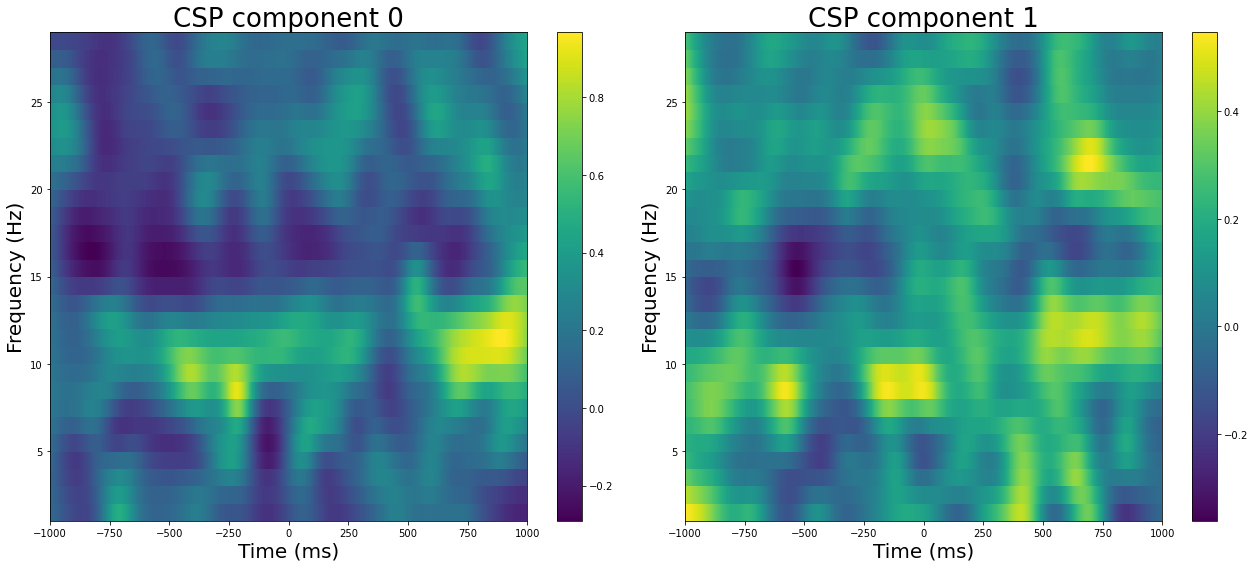

In [62]:
freqs = np.arange(1.0, 30.0, 1.0)
n_cycles = freqs / 2.0

tfr_low = tfr_array_morlet(
    X_csp_low,
    sfreq=info["sfreq"],
    freqs=freqs,
    n_cycles=n_cycles,
    output="power",
)
tfr_high = tfr_array_morlet(
    X_csp_high,
    sfreq=info["sfreq"],
    freqs=freqs,
    n_cycles=n_cycles,
    output="power",
)
fig, ax = plt.subplots(1, n_comp)
for i_comp in range(n_comp):

    mesh = ax[i_comp].pcolormesh(
        epochs["sub-01"].times * 1000,
        freqs,
        (tfr_high.mean(axis=0)[i_comp] - tfr_low.mean(axis=0)[i_comp]) / tfr_low.mean(axis=0)[i_comp],
        cmap="viridis",
    )
    ax[i_comp].set_title(f"CSP component {i_comp}", fontsize=26)
    ax[i_comp].set(ylim=freqs[[0, -1]], xlabel="Time (ms)", ylabel="Frequency (Hz)")
    ax[i_comp].xaxis.label.set_fontsize(20)
    ax[i_comp].yaxis.label.set_fontsize(20)
    fig.colorbar(mesh, ax=ax[i_comp])
    fig.set_size_inches(18,8)
plt.tight_layout()

In the `TFR` maps of relative power change above we can see that for the `CSP component 0` the relative power change is ~1.5-fold and is concentrated between 300 and 500 milliseconds after the answers onset for the frequencies up to 6 Hz. This is in line with what we've seen
on the PSD plot for `component 0`.

For `CSP component 1` the increase in power is more pronounced and is ~2.5-fold. It starts at around 250 milliseconds and seems to increase up to 1 second. The increase is concentrated in the alpha frequency band.

In [65]:
thresh_pv = 0.05
from functools import reduce

F_obs = [None] * n_comp
F_obs_plot = [None] * n_comp


for i_comp in range(n_comp):
    F_obs[i_comp], cl, cl_pv, H0 = permutation_cluster_test(
        [tfr_low[:, i_comp, ...], tfr_high[:, i_comp, ...]]
    )
    
    good_clusters = (np.where(cl_pv < thresh_pv)[0])
    if good_clusters.size:
        mask = np.logical_or.reduce(np.array(cl)[good_clusters], axis=0)
    else:
        mask = np.zeros_like(F_obs[i_comp], dtype=bool)
    F_obs_plot[i_comp] = np.ma.masked_array(F_obs[i_comp], np.invert(mask))

<ipython-input-66-5c5323a64c40>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[i_comp].pcolormesh(
<ipython-input-66-5c5323a64c40>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = ax[i_comp].pcolormesh(


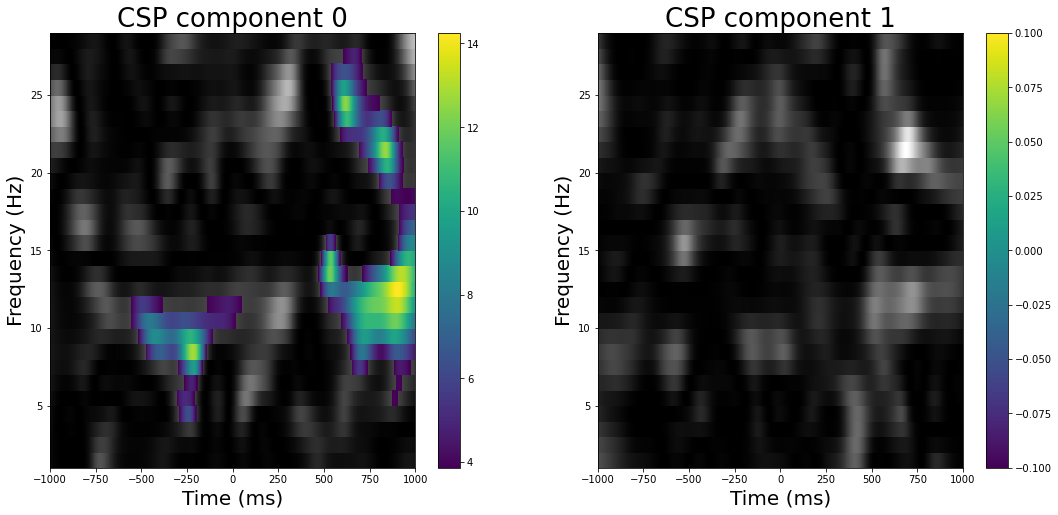

In [66]:
fig, ax = plt.subplots(1, n_comp)

for i_comp in range(n_comp):
    ax[i_comp].pcolormesh(
            epochs["sub-01"].times * 1000,
            freqs,
            F_obs[i_comp],
            cmap=plt.cm.gray,
        )
    mesh = ax[i_comp].pcolormesh(
            epochs["sub-01"].times * 1000,
            freqs,
            F_obs_plot[i_comp],
            cmap=plt.cm.viridis,
        )
    ax[i_comp].set_title(f"CSP component {i_comp}", fontsize=26)
    ax[i_comp].set(ylim=freqs[[0, -1]], xlabel="Time (ms)", ylabel="Frequency (Hz)")
    ax[i_comp].xaxis.label.set_fontsize(20)
    ax[i_comp].yaxis.label.set_fontsize(20)
    fig.colorbar(mesh, ax=ax[i_comp])
    fig.set_size_inches(18, 8)
plt.show()